In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df_sessions = pd.read_json(path_or_buf='../../data/raw/sessions.jsonl', lines=True)
df_users = pd.read_json(path_or_buf='../../data/raw/users.jsonl', lines=True)

In [3]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-07-28 15:47:21,102,1283,VIEW_PRODUCT,5,NaN
1,124,2021-07-28 15:47:40,102,1283,BUY_PRODUCT,5,20001.0
2,125,2021-09-12 16:43:16,102,1076,VIEW_PRODUCT,0,NaN
3,125,2021-09-12 16:46:24,102,1080,VIEW_PRODUCT,0,NaN
4,125,2021-09-12 16:48:08,102,1079,VIEW_PRODUCT,0,NaN


In [4]:
df_sessions.loc[df_sessions['session_id'] == 126]

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
11,126,2021-04-09 22:31:08,102,1281,VIEW_PRODUCT,15,NaN
12,126,2021-04-09 22:31:40,102,1278,VIEW_PRODUCT,15,NaN
13,126,2021-04-09 22:33:05,102,1278,BUY_PRODUCT,15,20003.0


In [5]:
df_users.head()

,user_id,name,city,street
0,102,Aurelia Malon,Poznań,pl. Brzoskwiniowa 11/53
1,103,Mateusz Kobel,Poznań,al. Wrocławska 10
2,104,Radosław Ratka,Szczecin,pl. Nowa 89/04
3,105,Anastazja Oszust,Warszawa,ul. Częstochowska 80
4,106,Sylwia Nurek,Warszawa,al. Wiosenna 72


# Data preprocessing

## Aggregate sessions information

In [6]:
aggregation_functions = {
    'timestamp' : lambda t: (t.max() - t.min()).seconds,
    'user_id' : 'first',
    'product_id' : 'unique',
    'event_type' : lambda e: 1 if len(e.unique()) > 1 else 0,
    'offered_discount' : 'first'
}
agg_sessions_df = df_sessions.groupby(df_sessions['session_id']).aggregate(aggregation_functions)
agg_sessions_df.rename(columns={'timestamp' :'session_length', 'event_type' : 'purchased'}, inplace=True)
agg_sessions_df.head()

,session_length,user_id,product_id,purchased,offered_discount
session_id,,,,,
124,19,102,[1283],1,5
125,1436,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",1,0
126,117,102,"[1281, 1278]",1,15
127,519,102,"[1278, 1281]",1,0
128,847,102,"[1008, 1007, 1013, 1012, 1004, 1010]",1,0


## Join user and sessions datasets

In [7]:
df = agg_sessions_df.join(other=df_users.set_index('user_id'), on='user_id')
df = df[['session_length', 'user_id', 'product_id', 'offered_discount', 'name', 'city', 'street', 'purchased']]
df.drop(columns=['name', 'street'], inplace=True)

In [8]:
df.head()

,session_length,user_id,product_id,offered_discount,city,purchased
session_id,,,,,,
124,19,102,[1283],5,Poznań,1
125,1436,102,"[1076, 1080, 1079, 1003, 1002, 1075, 1078, 1077]",0,Poznań,1
126,117,102,"[1281, 1278]",15,Poznań,1
127,519,102,"[1278, 1281]",0,Poznań,1
128,847,102,"[1008, 1007, 1013, 1012, 1004, 1010]",0,Poznań,1


# Data analysis

In [9]:
plt.style.use('seaborn')

Text(0, 0.5, 'Session length [s]')

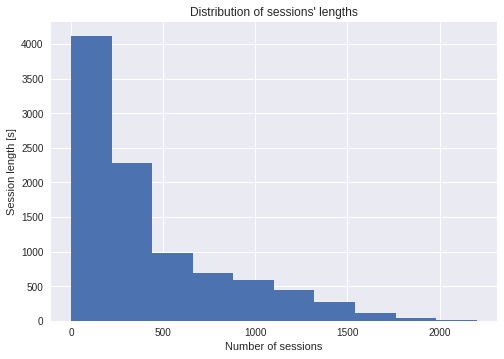

In [16]:
plt.hist(df['session_length'])
plt.title('Distribution of sessions\' lengths')
plt.xlabel('Number of sessions')
plt.ylabel('Session length [s]')

Analyse user cities of living

In [11]:
df['city'].value_counts()

Warszawa    2006
Poznań      1617
Gdynia      1446
Radom       1383
Szczecin    1138
Wrocław     1120
Kraków       817
Name: city, dtype: int64

Text(0, 0.5, 'Number of users')

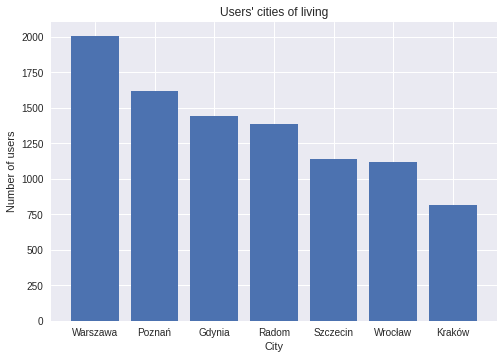

In [12]:
plt.bar(df['city'].value_counts().keys(), df['city'].value_counts())
plt.title('Users\' cities of living')
plt.xlabel('City')
plt.ylabel('Number of users')

Compare average number of products' views

In [13]:
not_purchased = df.loc[df['purchased'] == 0]
products_not_purchased = not_purchased['product_id'].values
avg_n_views_not_purchased = np.mean([len(product_list) for product_list in products_not_purchased])
avg_n_views_not_purchased

3.8565717141429285

In [14]:
purchased = df.loc[df['purchased'] == 1]
products_purchased = purchased['product_id'].values
avg_n_views_purchased = np.mean([len(product_list) for product_list in products_purchased])
avg_n_views_purchased

2.5420814479638008

Text(0, 0.5, 'Number of views')

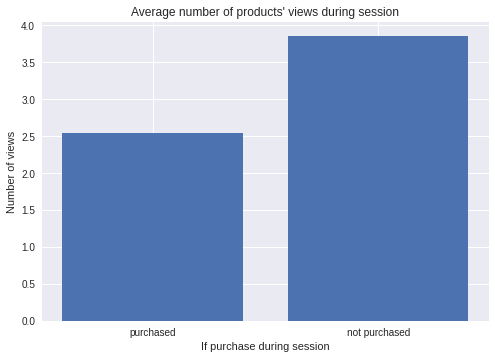

In [15]:
plt.bar(['purchased', 'not purchased'], [avg_n_views_purchased, avg_n_views_not_purchased])
plt.title('Average number of products\' views during session')
plt.xlabel('If purchase during session')
plt.ylabel('Number of views')

It is interesting that the chance of purchase during session gets smaller as the number of views of products gets bigger.

TODO: Plot session duration - probability of purchase